# 配置环境

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
import numpy as np
from scipy import stats
print("Setup Complete")

Setup Complete


# 差分隐私处理

## Step 1 import packages

In [91]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

## Step 2 user-defined parameteres

In [92]:
# input dataset
file_name = "insurance"
input_data = "./data/" + file_name + ".csv"
# location of two output files
mode = 'correlated_attribute_mode'
description_file = f"./out/{mode}/" + file_name + "_synthetic_description.json"
synthetic_data = f"./out/{mode}/" + file_name + "_synthetic_data.csv"

input_data, description_file, synthetic_data

('./data/insurance.csv',
 './out/correlated_attribute_mode/insurance_synthetic_description.json',
 './out/correlated_attribute_mode/insurance_synthetic_data.csv')

In [93]:
input_df = pd.read_csv(input_data)
input_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [94]:
input_df.shape

(1338, 7)

In [95]:
# An attribute is categorical if its domain size is less than this threshold.
# Here modify the threshold to adapt to the domain size of "education" (which is 14 in input dataset).
threshold_value = 20

# specify categorical attributes
# categorical_attributes = {'education': True}
categorical_attributes = {}

# specify which attributes are candidate keys of input dataset.
# candidate_keys = {'ssn': True}
candidate_keys = {}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 30

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 2

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = input_df.shape[0] # Here input_df.shape[0] is the same as input dataset, but it can be set to another number.

## Step 3 DataDescriber

1. Instantiate a DataDescriber.
2. Compute the statistics of the dataset.
3. Save dataset description to a file on local machine.

In [96]:
describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon, 
                                                        k=degree_of_bayesian_network,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)

================ Constructing Bayesian Network (BN) ================
Adding ROOT charges
Adding attribute age
Adding attribute smoker
Adding attribute bmi
Adding attribute children
Adding attribute region
Adding attribute sex
========================== BN constructed ==========================


In [97]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    age      has parents ['charges'].
    smoker   has parents ['age', 'charges'].
    bmi      has parents ['age', 'charges'].
    children has parents ['bmi', 'age'].
    region   has parents ['bmi', 'age'].
    sex      has parents ['bmi', 'age'].


## Step 4 generate synthetic dataset

1. Instantiate a DataGenerator.
2. Generate a synthetic dataset.
3. Save it to local machine.

In [98]:
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

## Step 5 compare the statistics of input and sythetic data (optional)

The synthetic data is already saved in a file by step 4. The ModelInspector is for a quick test on the similarity between input and synthetic datasets.

### 5.1 instantiate a ModelInspector.

It needs input dataset, synthetic dataset, and attribute description.

In [99]:
input_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [100]:
synthetic_df = pd.read_csv(synthetic_data)
synthetic_df.head()

,age,sex,bmi,children,smoker,region,charges
0,57.0,female,17.960060,4,no,northeast,12803.373133
1,31.0,male,17.280966,2,yes,northwest,19348.064712
2,49.0,female,28.376311,0,no,northeast,11089.940263
3,55.0,male,28.556532,0,no,southwest,13076.408851
4,54.0,female,31.840721,2,no,northeast,10366.546432


In [101]:
synthetic_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [102]:
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']

inspector = ModelInspector(input_df, synthetic_df, attribute_description)

### 5.2 compare histograms between input and synthetic datasets.

age
sex
bmi
children
smoker
region
charges


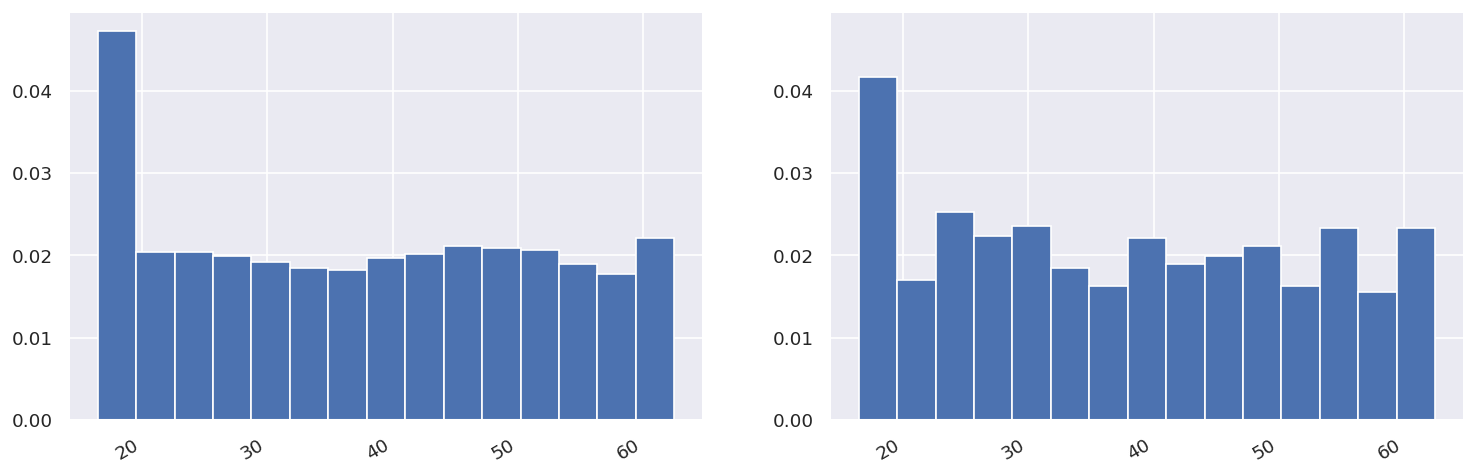

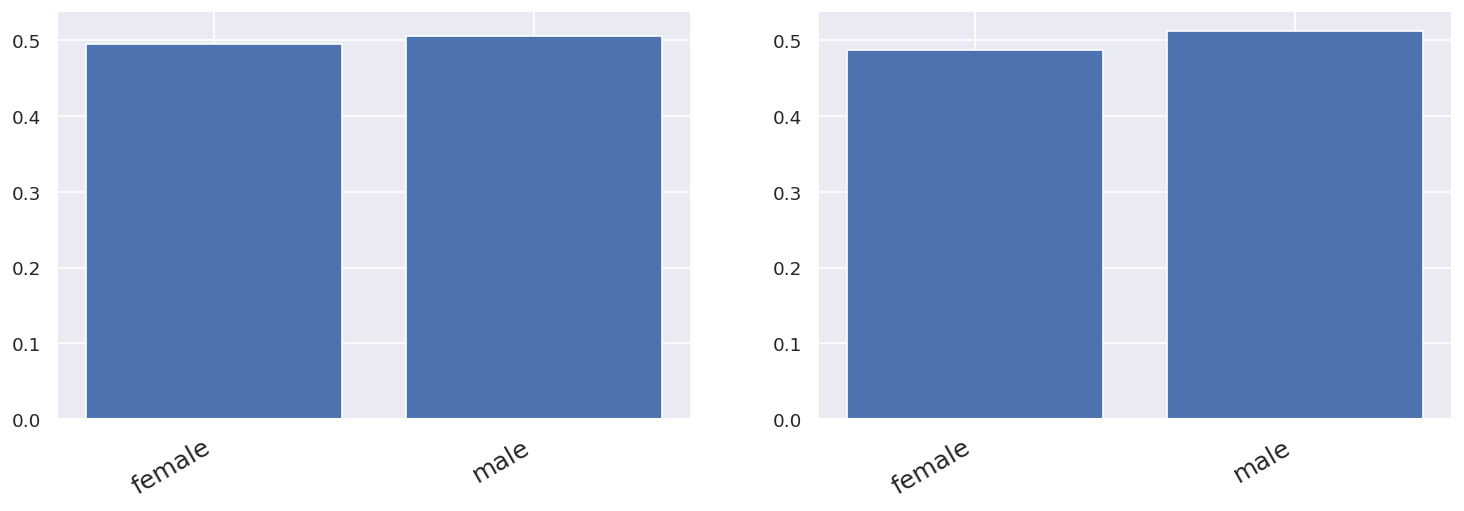

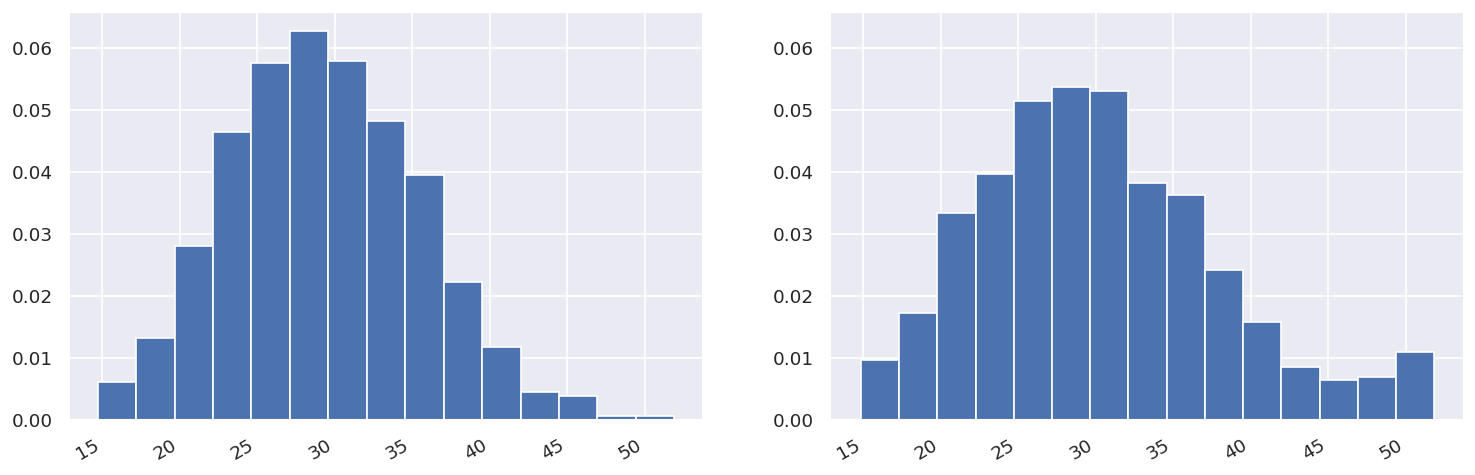

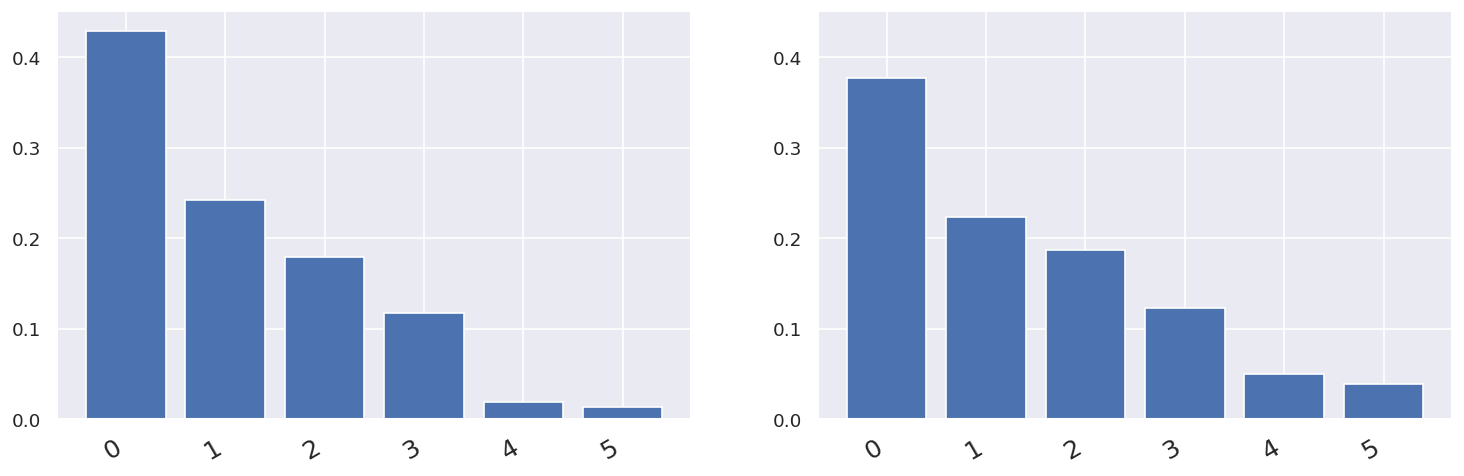

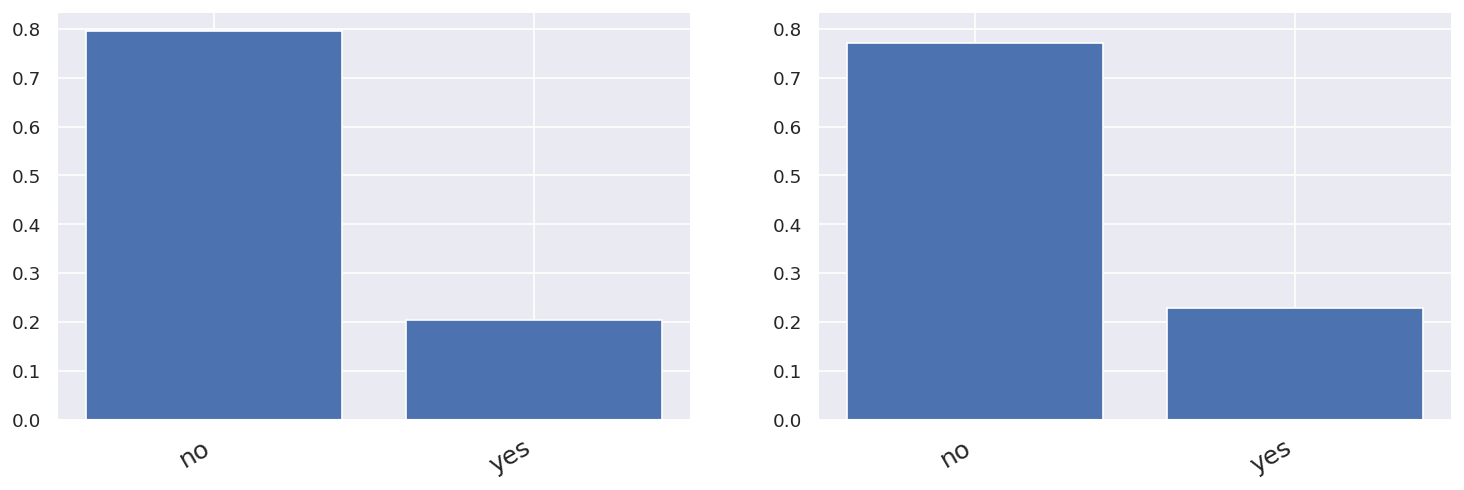

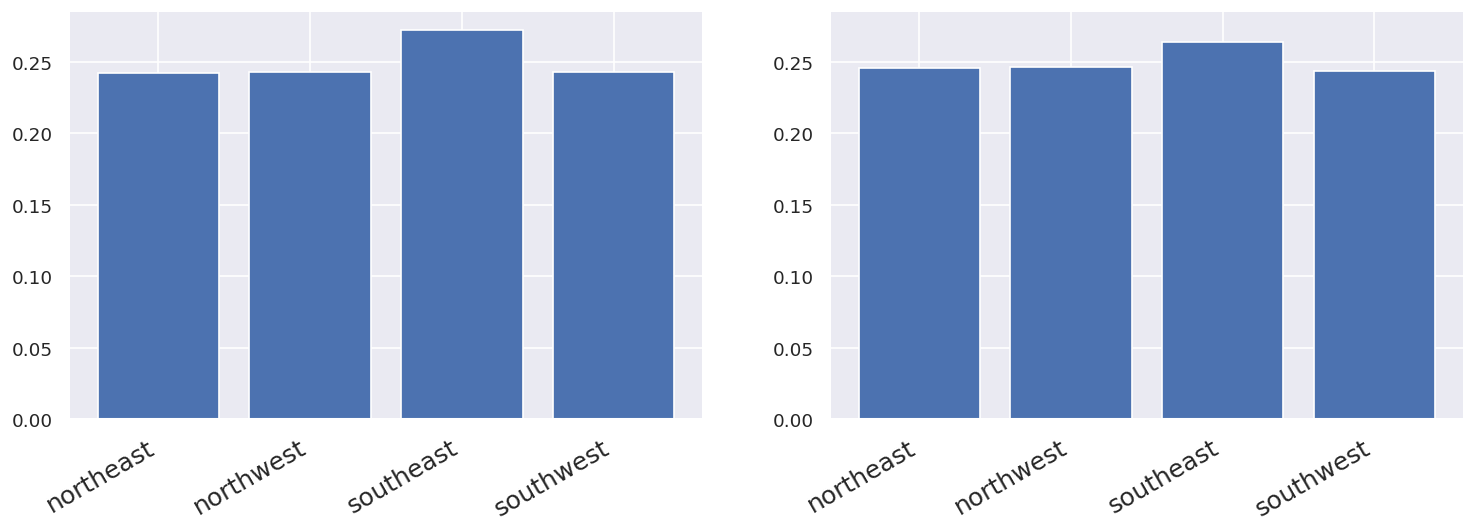

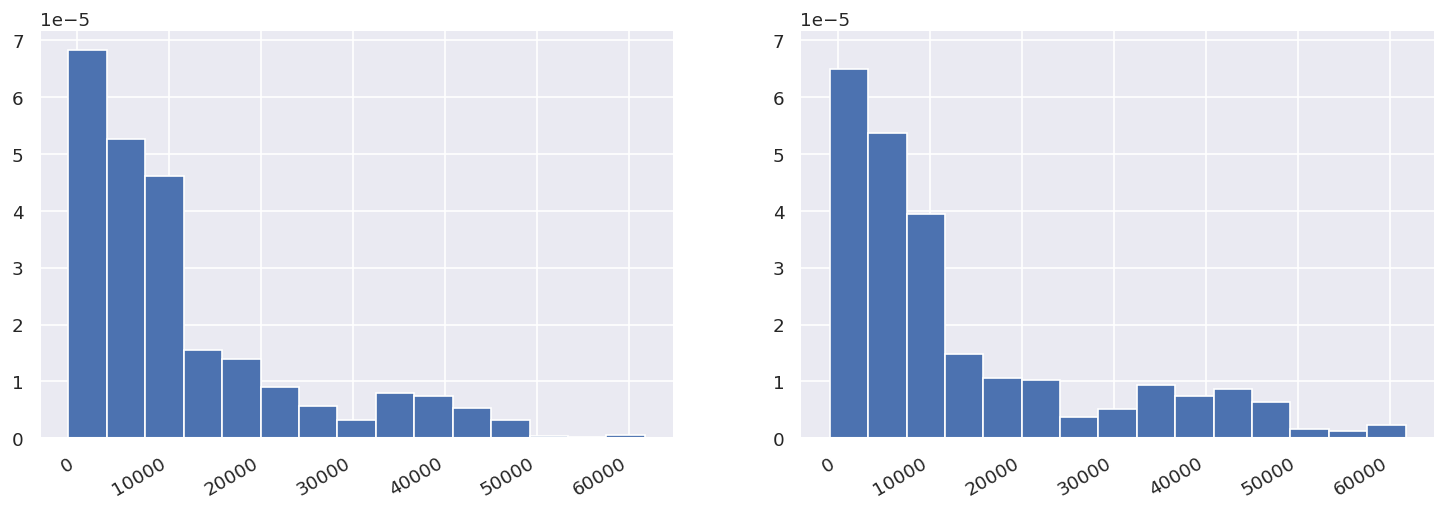

In [103]:
for attribute in synthetic_df.columns:
    print(attribute)
    inspector.compare_histograms(attribute)

### 5.3 compare pairwise mutual information

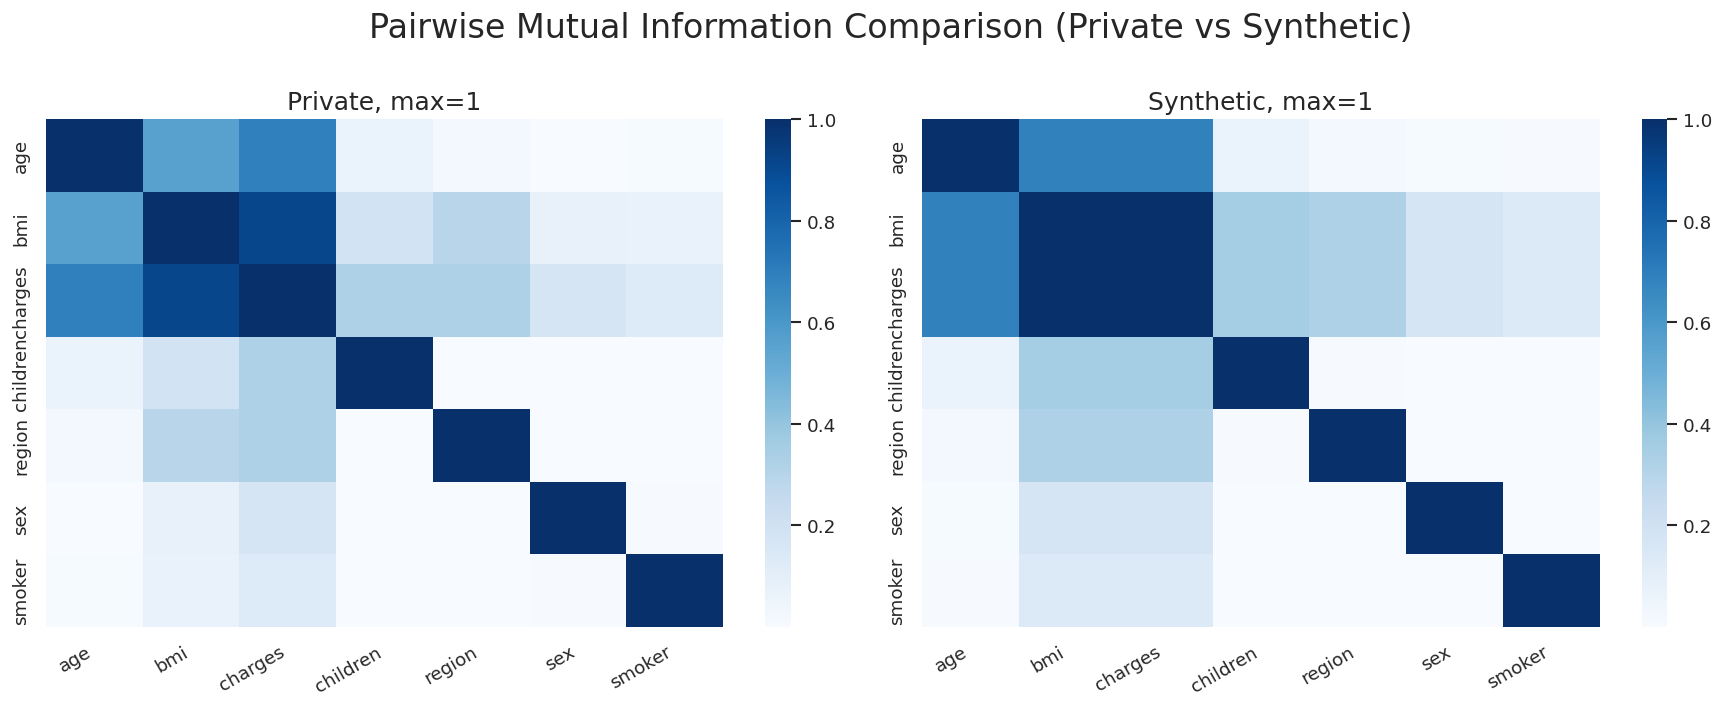

In [104]:
inspector.mutual_information_heatmap()

# 其他种类可视化的比较

In [105]:
# sns.color_palette()

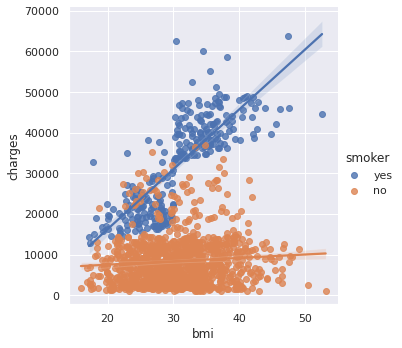

In [106]:
sns.lmplot(x="bmi", y="charges", hue="smoker", data=input_df, palette=dict(yes=sns.color_palette()[0], no=sns.color_palette()[1]))

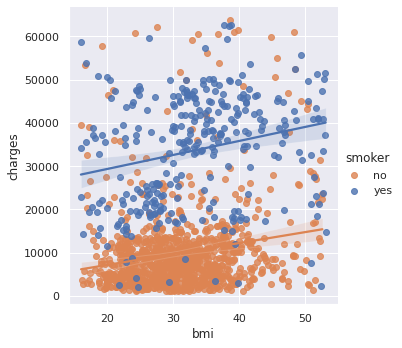

In [107]:
sns.lmplot(x="bmi", y="charges", hue="smoker", data=synthetic_df, palette=dict(yes=sns.color_palette()[0], no=sns.color_palette()[1]))

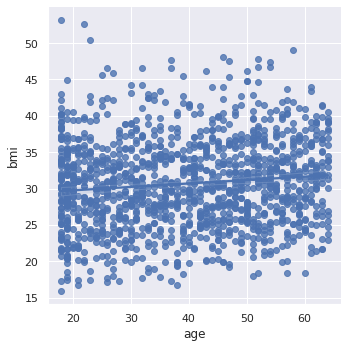

In [108]:
sns.lmplot(x="age", y="bmi", data=input_df, palette=dict(yes=sns.color_palette()[0], no=sns.color_palette()[1]))

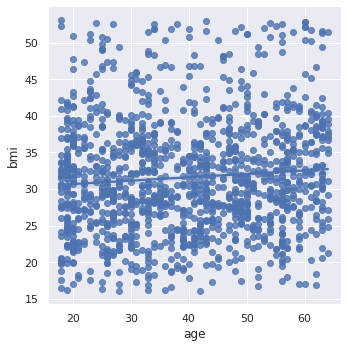

In [109]:
sns.lmplot(x="age", y="bmi", data=synthetic_df, palette=dict(yes=sns.color_palette()[0], no=sns.color_palette()[1]))

In [110]:
input_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


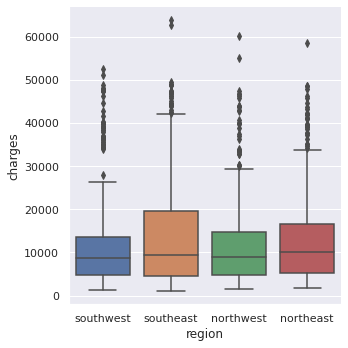

In [111]:
sns.catplot(x='region', y='charges', kind="box", data=input_df)

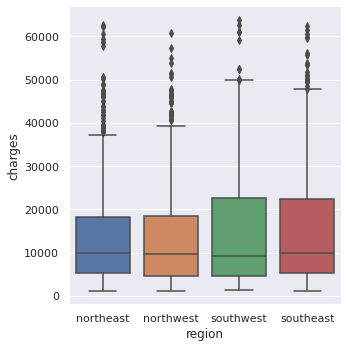

In [112]:
sns.catplot(x='region', y='charges', kind="box", data=synthetic_df)

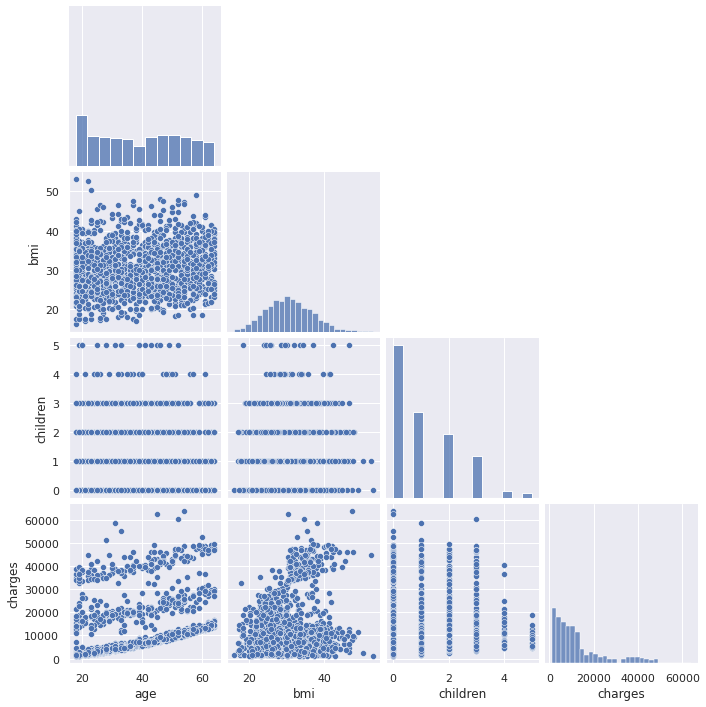

In [113]:
original_sns_plot = sns.pairplot(input_df, corner=True)

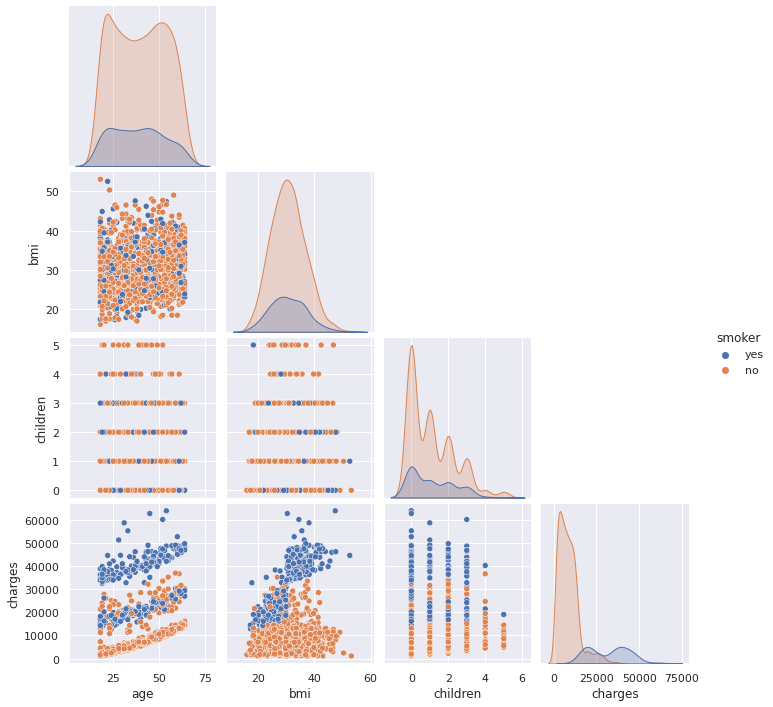

In [114]:
original_sns_plot = sns.pairplot(input_df, hue='smoker', corner=True)

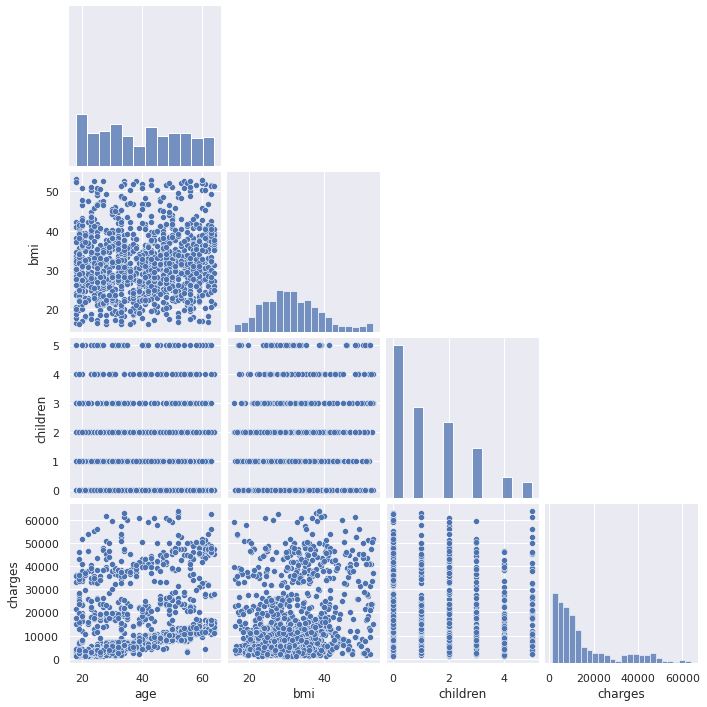

In [115]:
synthetic_sns_plot = sns.pairplot(synthetic_df, corner=True)

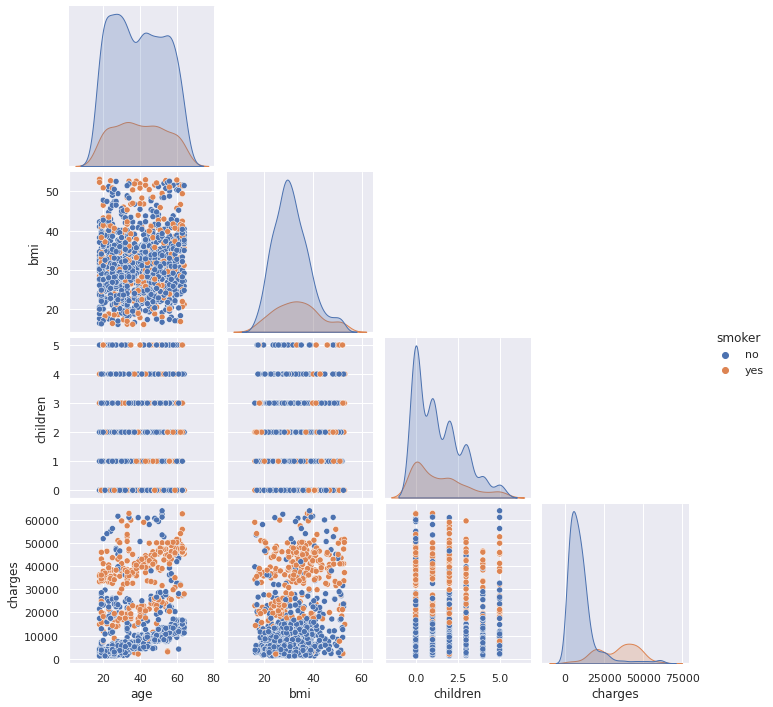

In [116]:
synthetic_sns_plot = sns.pairplot(synthetic_df, hue='smoker', corner=True)

# 指标比较

## Correlation 比较

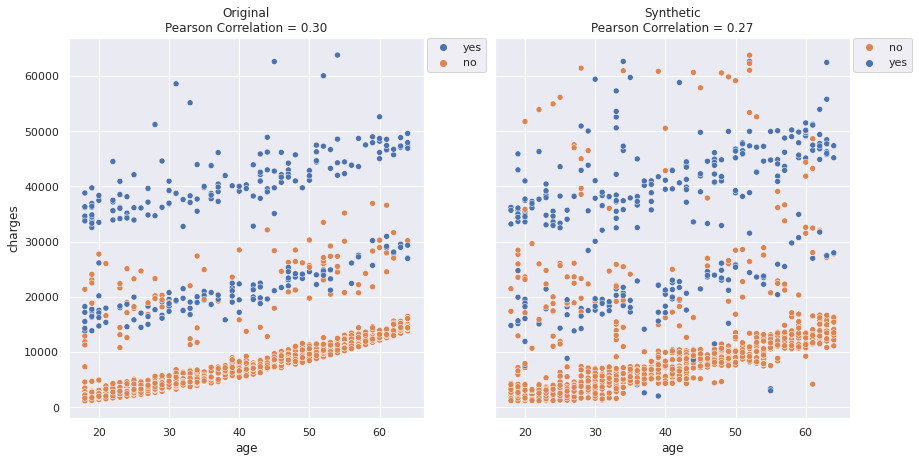

In [117]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(14, 7))
ax = sns.scatterplot(data=input_df, x="age", y="charges", hue='smoker', palette=dict(yes=sns.color_palette()[0], no=sns.color_palette()[1]), ax=ax1)
cor = np.corrcoef(input_df['age'].to_numpy(), input_df['charges'].to_numpy())
ax.title.set_text('Original\n' + 'Pearson Correlation = ' + "{:.2f}".format(cor[0, 1]))
ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax = sns.scatterplot(data=synthetic_df, x="age", y="charges", hue='smoker', palette=dict(yes=sns.color_palette()[0], no=sns.color_palette()[1]), ax=ax2)
cor = np.corrcoef(synthetic_df['age'].to_numpy(), synthetic_df['charges'].to_numpy())
ax.title.set_text('Synthetic\n' + 'Pearson Correlation = ' + "{:.2f}".format(cor[0, 1]))
ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

## Cluster 比较

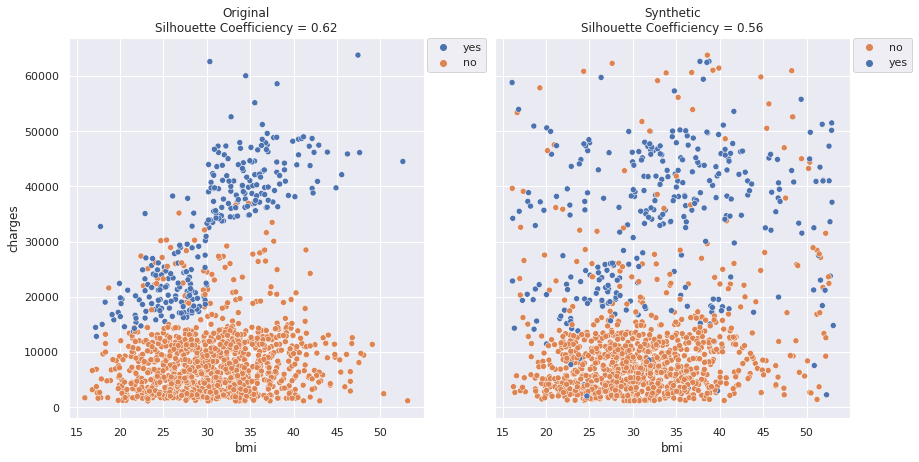

In [118]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(14, 7))
ax = sns.scatterplot(data=input_df, x="bmi", y="charges", hue='smoker', palette=dict(yes=sns.color_palette()[0], no=sns.color_palette()[1]), ax=ax1)
z = input_df[['bmi', 'charges']]
label = input_df['smoker'].map(dict(yes=1, no=0)).to_numpy()
s = silhouette_score(z, label)
ax.title.set_text('Original\n' + 'Silhouette Coefficiency = ' + "{:.2f}".format(s))
ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax = sns.scatterplot(data=synthetic_df, x="bmi", y="charges", hue='smoker', palette=dict(yes=sns.color_palette()[0], no=sns.color_palette()[1]), ax=ax2)
z = synthetic_df[['bmi', 'charges']]
label = synthetic_df['smoker'].map(dict(yes=1, no=0)).to_numpy()
s = silhouette_score(z, label)
ax.title.set_text('Synthetic\n' + 'Silhouette Coefficiency = ' + "{:.2f}".format(s))
ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

## Order比较

In [119]:
x1 = input_df['children'].value_counts().sort_index()
x2 = synthetic_df['children'].value_counts().sort_index()
tau, p_value = stats.kendalltau(x1, x2)
rho, pval = stats.spearmanr(x1, x2)

Text(0.5, 0.98, 'Kendall Tau = 1.00; Spearman Rho = 1.00')

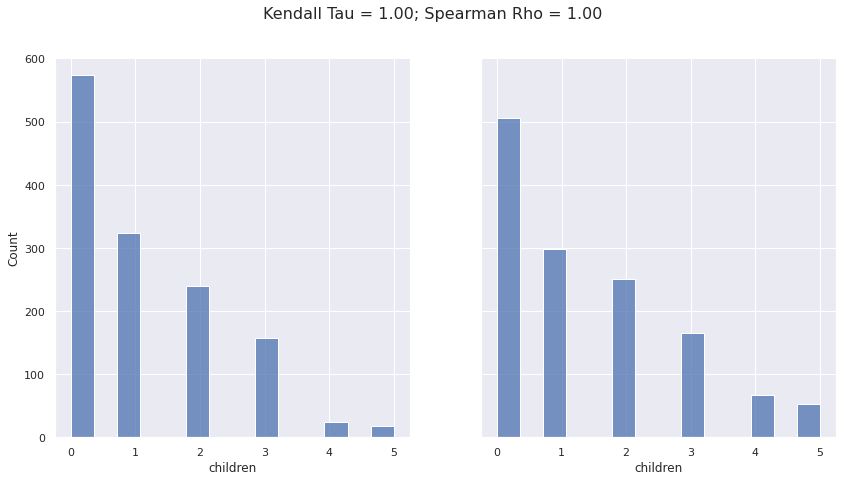

In [121]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(14, 7))
ax = sns.histplot(data=input_df, x="children", ax=ax1)
ax = sns.histplot(data=synthetic_df, x="children", ax=ax2)
fig.suptitle('Kendall Tau = ' + "{:.2f}".format(tau) + '; Spearman Rho = ' + "{:.2f}".format(rho), fontsize=16)